##### 1. Import the packages and load the stock price data using ‘StockPricePrediction.ipynb’.


In [1]:
# Libraries for data preparation and visualization
import numpy as np
import pandas as pd

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import datetime

from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

# Libraries for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Libraries for statistical models
import statsmodels.api as sm

# Libraries for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Libraries for the deep learning models
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['^GSPC', '^DJI', '^VIX']
idx_tickers_name = ['SP500', 'DJIA', 'VIXCLS']

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

stk_data = web.get_data_yahoo(stk_tickers, start_date, end_date)
ccy_data = web.get_data_fred(ccy_tickers, start_date, end_date)
idx_data = web.get_data_yahoo(idx_tickers, start_date, end_date)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


##### 2. Split the data into the training set and the test set.


In [3]:
return_period = 5

Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data.loc[:, ('Adj Close', ('^GSPC', '^DJI', '^VIX'))]).diff(return_period)
X3.columns = idx_tickers_name
#X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [4]:
test_size = 0.2
train_size = int(len(X) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

##### 3. Prepare the data for the LSTM models.


In [5]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [6]:
X_train_LSTM.shape

(372, 2, 11)

##### 4. Create the following 3 models using Keras.


##### ① 1 LSTM layer with 50 outputs and 1 Dense layer with 1 output


In [7]:
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model1.add(Dense(1))

##### ② 1 LSTM layer with 1 output


In [8]:
model2 = Sequential()
model2.add(LSTM(1, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

##### ③ 1 LSTM layer with 50 outputs, 1 Dense layer with 10 outputs, and 1 Dense layer with 1 output

In [9]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model3.add(Dense(10))
model3.add(Dense(1))

##### 5. Print the summary of the models or create plots for the models.

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12451 (48.64 KB)
Trainable params: 12451 (48.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


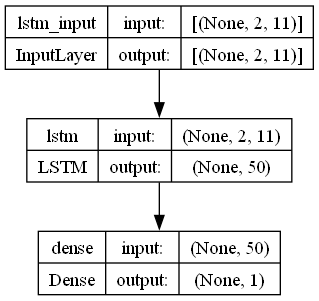

In [11]:
keras.utils.plot_model(model1, show_shapes=True)

In [12]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1)                 52        
                                                                 
Total params: 52 (208.00 Byte)
Trainable params: 52 (208.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


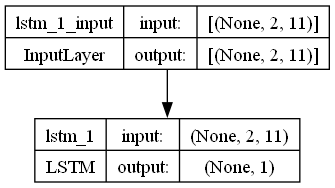

In [13]:
keras.utils.plot_model(model2, show_shapes=True)

In [14]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                12400     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12921 (50.47 KB)
Trainable params: 12921 (50.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


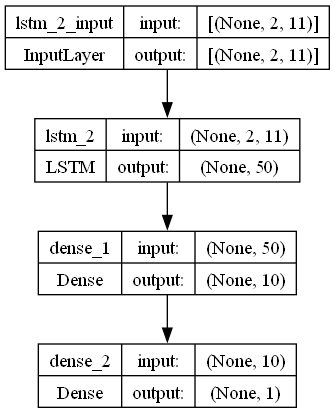

In [15]:
keras.utils.plot_model(model3, show_shapes=True)

##### 6. Compile each model using the MSE as the loss function and the Adam as the optimizer.


In [16]:
model1.compile(loss='mse', optimizer='adam')
model2.compile(loss='mse', optimizer='adam')
model3.compile(loss='mse', optimizer='adam')

##### 7. Fit each model using the training set with epochs 20. Use the test set as the validation set.


In [17]:
LSTMModel_fit1 = model1.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                          epochs=20, batch_size=72, verbose=0, shuffle=False)
LSTMModel_fit2 = model2.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                          epochs=20, batch_size=72, verbose=0, shuffle=False)
LSTMModel_fit3 = model3.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                          epochs=20, batch_size=72, verbose=0, shuffle=False)

##### 8. Check the value of the last validation loss and compare 3 models. Use the best model as our final model.

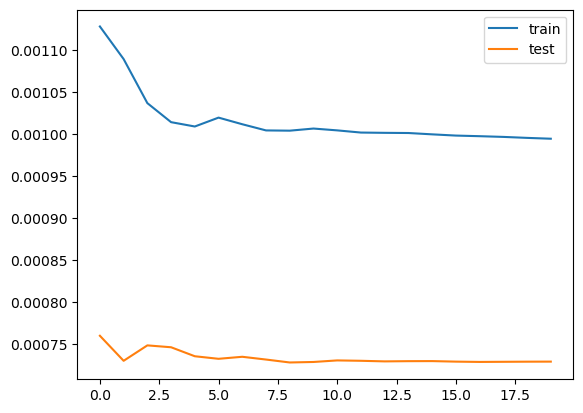

In [18]:
pyplot.plot(LSTMModel_fit1.history['loss'], label='train')
pyplot.plot(LSTMModel_fit1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

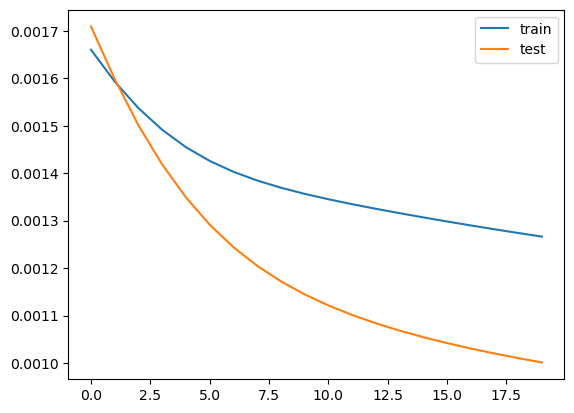

In [19]:
pyplot.plot(LSTMModel_fit2.history['loss'], label='train')
pyplot.plot(LSTMModel_fit2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

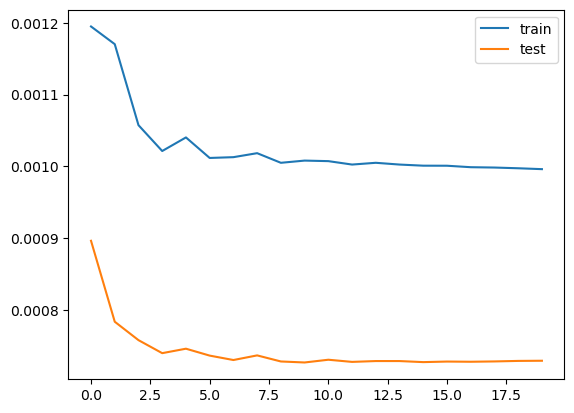

In [20]:
pyplot.plot(LSTMModel_fit3.history['loss'], label='train')
pyplot.plot(LSTMModel_fit3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
predicted = model1.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

3/3 [==============================] - 0s 6ms/step
0.0007288593334614211


In [24]:
predicted = model2.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

3/3 [==============================] - 1s 5ms/step
0.001001102737257205


In [25]:
predicted = model3.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

3/3 [==============================] - 1s 6ms/step
0.0007288147809656833


##### 9. Make predictions based on the final model using the test set and create the line graph comparing actual and predicted values

3/3 [==============================] - 1s 6ms/step
0.0007288593334614211


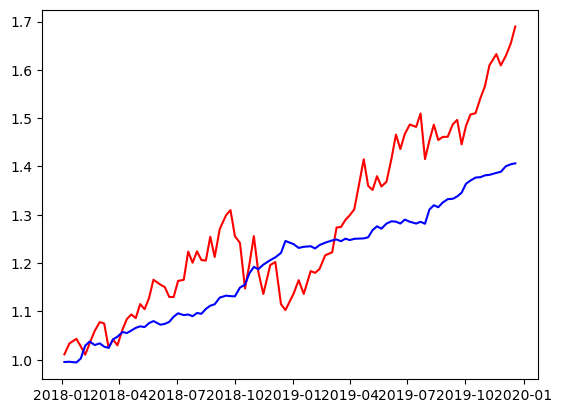

In [22]:
predicted = model1.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

predicted = pd.DataFrame(predicted)
predicted.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8, 6)
pyplot.show()

3/3 [==============================] - 0s 6ms/step
0.0007288147809656833


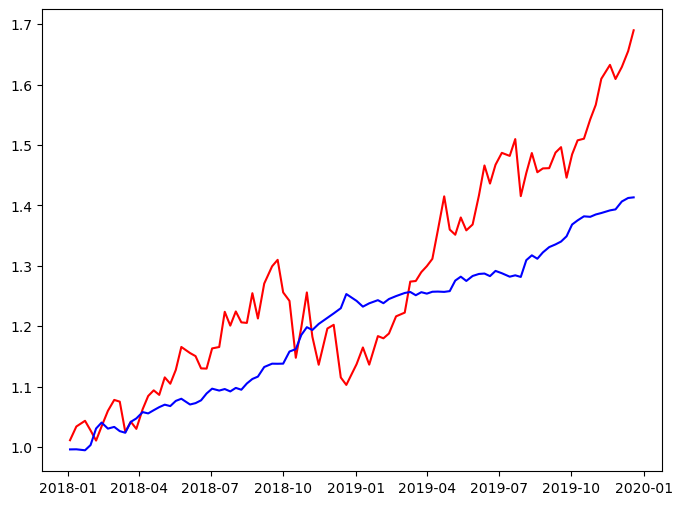

In [28]:
predicted = model3.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

predicted = pd.DataFrame(predicted)
predicted.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8, 6)
pyplot.show()